In [1]:
import tensorflow as tf
import numpy as np
from utils import plot_images, read_mnist_data, add_variable_histogram_summaries
from time import time
from os.path import exists

In [2]:
data, _ = read_mnist_data()

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Data shapes:
Training - x: (55000, 784), y:(55000, 10)
Test - x: (10000, 784), y:(10000, 10)
Validation - x: (5000, 784), y:(5000, 10)


In [3]:
def generator(z):
    x_gen = tf.layers.dense(z, 128, tf.nn.relu, name='fc1')
    return tf.layers.dense(x_gen, 784, tf.nn.sigmoid, name='fc2')

In [4]:
def discriminator(x):
    p = tf.layers.dense(x, 128, tf.nn.relu, name='fc1')
    return tf.layers.dense(p, 1, tf.nn.sigmoid, name='fc2')

In [5]:
def Q(x):
    p = tf.layers.dense(x, 128, tf.nn.relu, name='fc1')
    return tf.layers.dense(p, 1, tf.nn.sigmoid, name='fc2')

In [29]:
tf.reset_default_graph()

z_dim = 32

with tf.name_scope('inputs'):
    x = tf.placeholder(tf.float32, (None, 784), 'x')
    z = tf.placeholder(tf.float32, (None, z_dim), 'z')
    c = tf.placeholder(tf.float32, (None, 10), 'c')
    
with tf.variable_scope('generator'):
    x_gen = generator(z)
    
with tf.variable_scope('discriminator'):
    p_x = discriminator(x)
    tf.get_variable_scope().reuse_variables()
    p_g = discriminator(x_gen)
    
with tf.variable_scope('Q'):
    q_c1x = Q(x_gen)
    
with tf.name_scope('optimizer'):
    loss_d = -tf.reduce_mean(tf.log(p_x) + tf.log(1 - p_g), name='disc_loss')
    loss_g = -tf.reduce_mean(tf.log(p_g), name='gen_loss')
    loss_q = -tf.reduce_mean(tf.reduce_sum(tf.log(q_c1x) * c, 1)) - tf.reduce_mean(tf.reduce_sum(tf.log(c) * c, 1))
    optimize_d = tf.train.AdamOptimizer(1e-4).minimize(loss_d, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator'))
    optimize_g = tf.train.AdamOptimizer(1e-4).minimize(loss_g, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator'))
    optimize_q = tf.train.AdamOptimizer().minimize(loss_q, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'Q'))
    
tf.summary.scalar('loss_d', loss_d)
tf.summary.scalar('loss_g', loss_g)
tf.summary.scalar('loss_q', loss_g)
add_variable_histogram_summaries()
summ = tf.summary.merge_all()

saver = tf.train.Saver()

INFO:tensorflow:Summary name generator/fc1/kernel:0 is illegal; using generator/fc1/kernel_0 instead.
INFO:tensorflow:Summary name generator/fc1/bias:0 is illegal; using generator/fc1/bias_0 instead.
INFO:tensorflow:Summary name generator/fc2/kernel:0 is illegal; using generator/fc2/kernel_0 instead.
INFO:tensorflow:Summary name generator/fc2/bias:0 is illegal; using generator/fc2/bias_0 instead.
INFO:tensorflow:Summary name discriminator/fc1/kernel:0 is illegal; using discriminator/fc1/kernel_0 instead.
INFO:tensorflow:Summary name discriminator/fc1/bias:0 is illegal; using discriminator/fc1/bias_0 instead.
INFO:tensorflow:Summary name discriminator/fc2/kernel:0 is illegal; using discriminator/fc2/kernel_0 instead.
INFO:tensorflow:Summary name discriminator/fc2/bias:0 is illegal; using discriminator/fc2/bias_0 instead.
INFO:tensorflow:Summary name Q/fc1/kernel:0 is illegal; using Q/fc1/kernel_0 instead.
INFO:tensorflow:Summary name Q/fc1/bias:0 is illegal; using Q/fc1/bias_0 instead.


In [23]:
def plot_generated_images(sess, label=None):
    if label is None:
        labels = np.random.multinomial(1, [0.1]*10, 11)
    else:
        labels = np.zeros((11, 10))
        labels[range(11), label] = 1
        
    generated_images = sess.run(x_gen, feed_dict={c: labels, z: np.random.uniform(-1, 1, (11, z_dim))})
    plot_images(generated_images.reshape((-1, 784)), np.argmax(labels, 1))

In [26]:
batch_size = 16
k_disc = 1

batches_per_epoch = int(data.train.num_examples / batch_size)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

def optimize(epochs=1):
    start_time = time()
    
    writer = tf.summary.FileWriter('checkpoints/GAN', tf.get_default_graph())
    
    with tf.Session(config=config) as sess:
        if exists('checkpoints/GAN/GAN.data-00000-of-00001'):
            saver.restore(sess, 'checkpoints/GAN/GAN')
        else:
            sess.run(tf.global_variables_initializer())
        
        for epoch in range(epochs):
            for batch in range(batches_per_epoch):
                x_batch, _ = data.train.next_batch(batch_size)
                z_batch = np.random.uniform(-1, 1, (batch_size, z_dim))
                c_batch = np.random.multinomial(1, [0.1]*10, batch_size)
                for _ in range(k_disc):
                    sess.run(optimize_d, feed_dict={x: x_batch, c: c_batch, z: z_batch})
                
                sess.run(optimize_g, feed_dict={c: c_batch, z: z_batch})
                sess.run(optimize_q, feed_dict={c: c_batch, z: z_batch})

                if (epoch * batches_per_epoch + batch) % 100 == 0:
                    writer.add_summary(sess.run(summ, feed_dict={x: x_batch, c: c_batch, z: z_batch}), global_step=epoch * batches_per_epoch + batch)
            
            print("{} / {} ({}%)".format(epoch + 1, epochs, np.round((epoch + 1) / epochs * 100, 2)))
            plot_generated_images(sess)
            
        saver.save(sess, 'checkpoints/GAN/GAN', write_meta_graph=False)
        
    print("Time taken - {}s".format(np.round(time() - start_time, 2)))
    writer.close()

INFO:tensorflow:Restoring parameters from checkpoints/GAN/GAN


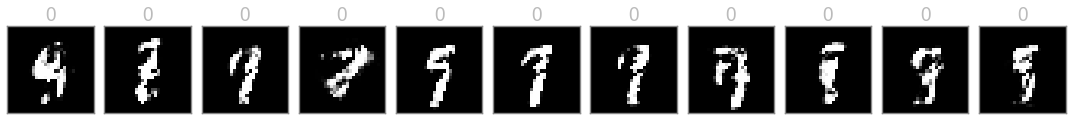

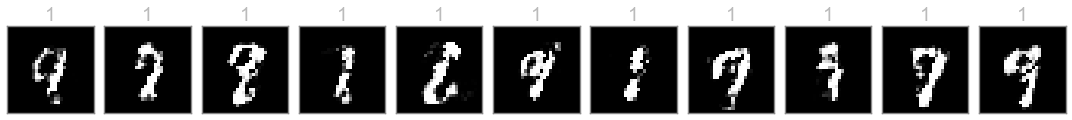

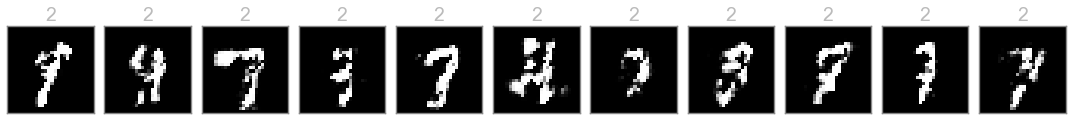

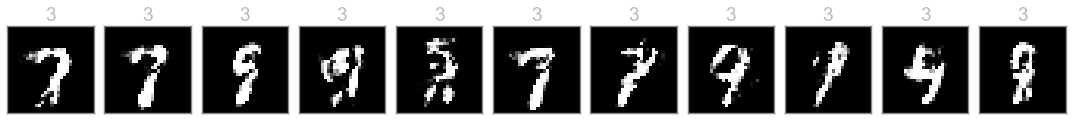

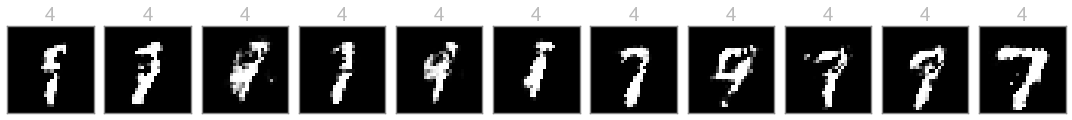

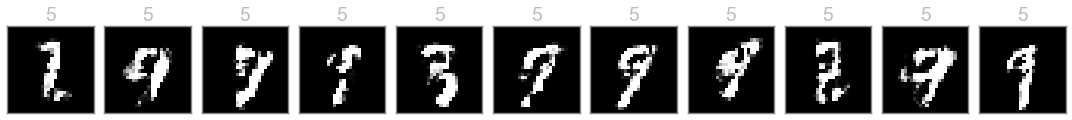

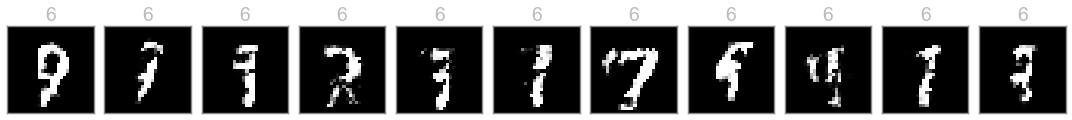

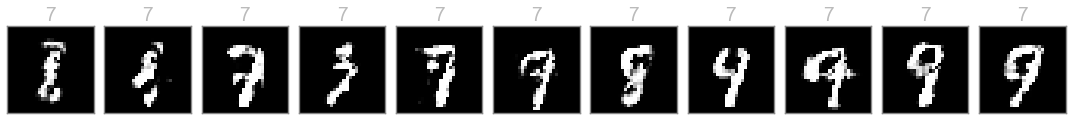

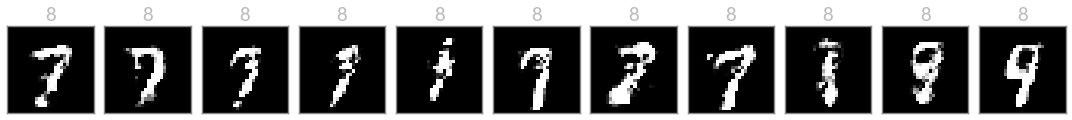

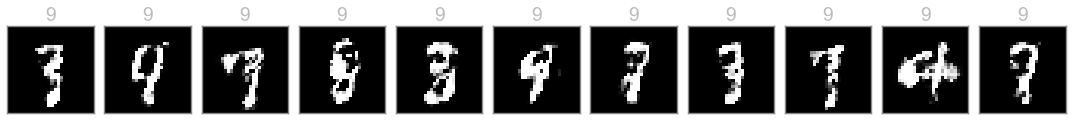

In [32]:
with tf.Session(config=config) as sess:
        if exists('checkpoints/GAN/GAN.data-00000-of-00001'):
            saver.restore(sess, 'checkpoints/GAN/GAN')
        else:
            sess.run(tf.global_variables_initializer())
        
        for i in range(10):
            plot_generated_images(sess, i)

1 / 20 (5.0%)


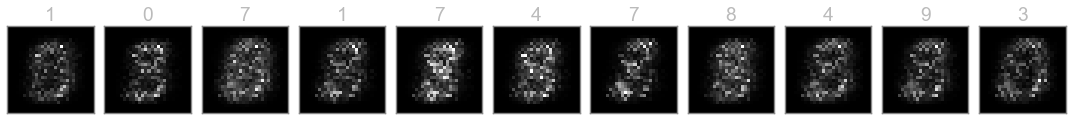

2 / 20 (10.0%)


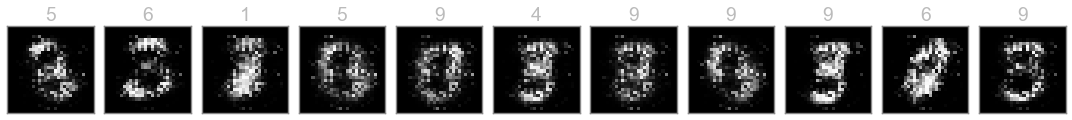

3 / 20 (15.0%)


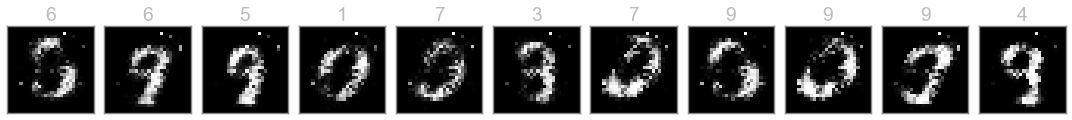

4 / 20 (20.0%)


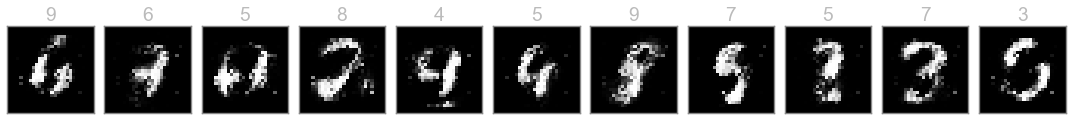

5 / 20 (25.0%)


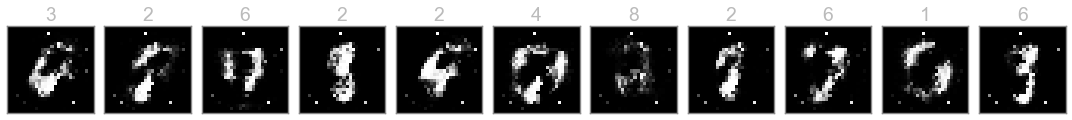

6 / 20 (30.0%)


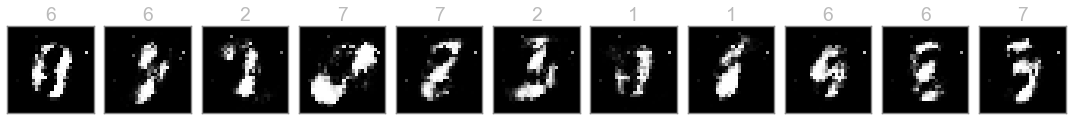

7 / 20 (35.0%)


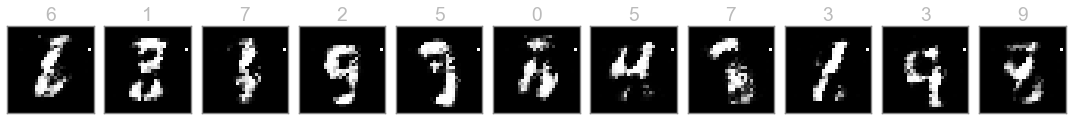

8 / 20 (40.0%)


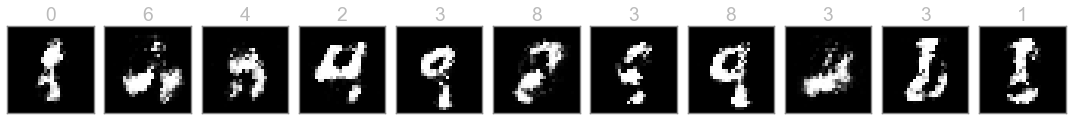

9 / 20 (45.0%)


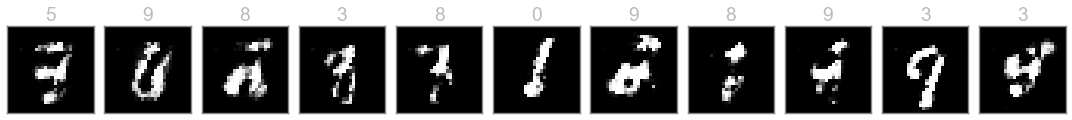

10 / 20 (50.0%)


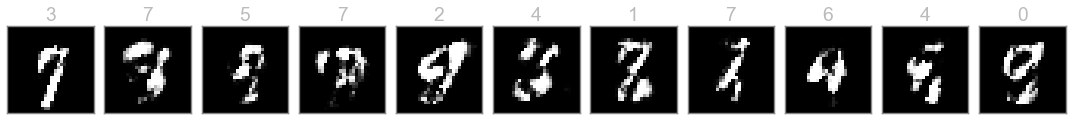

11 / 20 (55.0%)


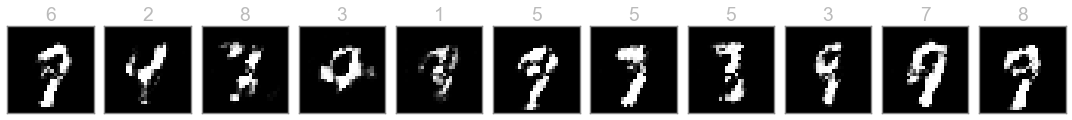

12 / 20 (60.0%)


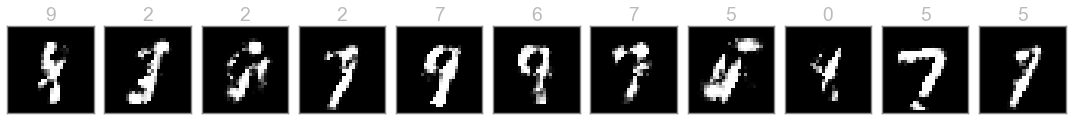

13 / 20 (65.0%)


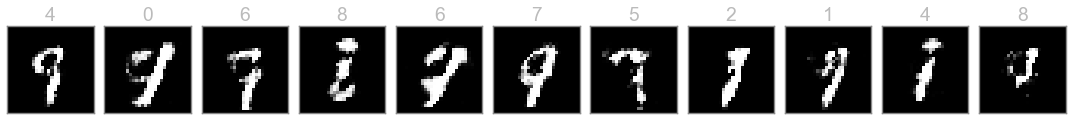

14 / 20 (70.0%)


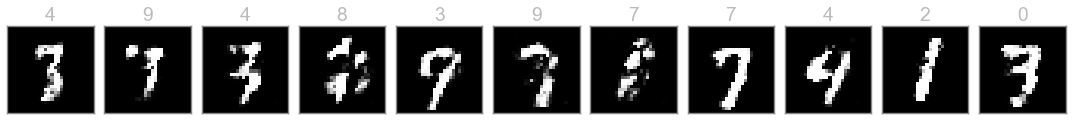

15 / 20 (75.0%)


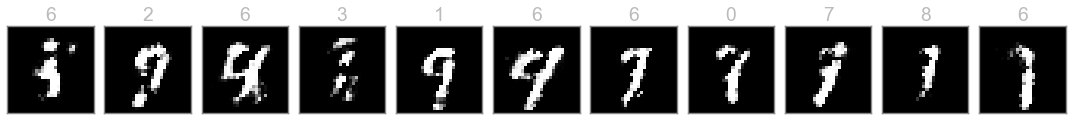

16 / 20 (80.0%)


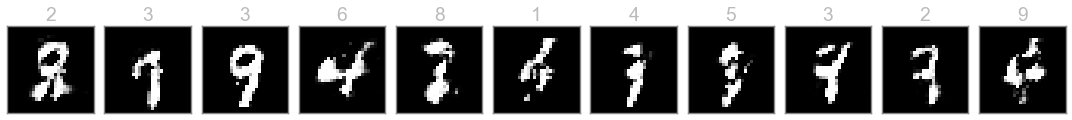

17 / 20 (85.0%)


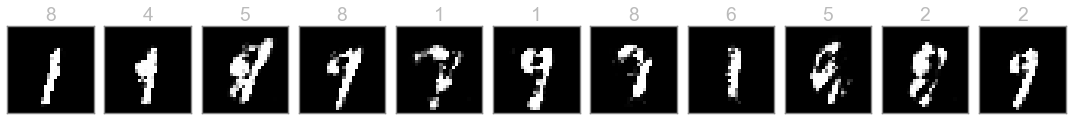

18 / 20 (90.0%)


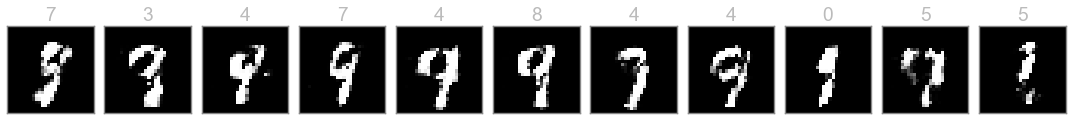

19 / 20 (95.0%)


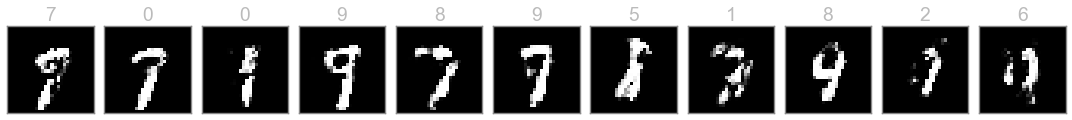

20 / 20 (100.0%)


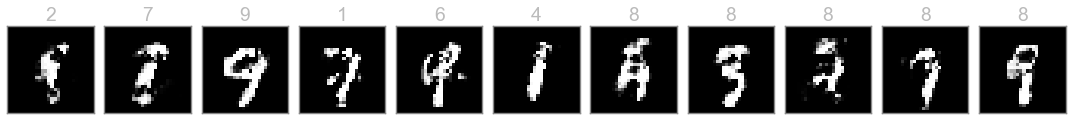

Time taken - 144.19s


In [31]:
optimize(20)